In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha
import fibonacci_sphere
import xyzfield
import bspline

import importlib
importlib.reload(scha)

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

### generar puntos

In [2]:
def angulardist(theta1, phi1, theta2, phi2):
    return numpy.arccos(sin(theta1)*sin(theta2)*cos(phi1 - phi2)+cos(theta1)*cos(theta2))

In [3]:
theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 20.0))
lat_c, lon_c = 90 - numpy.rad2deg(theta_c), numpy.rad2deg(phi_c)

thetav, phiv = fibonacci_sphere.grid(800)
inside_cap_index = angulardist(thetav, phiv, theta_c, phi_c) < theta_0d
thetav = thetav[inside_cap_index]
phiv = phiv[inside_cap_index]

n_space = len(thetav)
n_time = 100

### generar tiempos

In [4]:
import numpy.random, datetime
numpy.random.seed(1994)

date = datetime.datetime(2014, 1, 1)
ref = datetime.datetime(2000, 1, 1)

mjd_max = (date - ref).total_seconds()/(24*3600)
mjd_min = (ref - ref).total_seconds()/(24*3600)

t = (mjd_max - mjd_min) * numpy.random.random(n_time) + mjd_min

### archivo mágico

In [5]:
lat = numpy.tile(90 - numpy.rad2deg(thetav), n_time)
lon = numpy.tile(numpy.rad2deg(phiv), n_time)
thetav = numpy.tile(thetav, n_time)
phiv = numpy.tile(phiv, n_time)
r = numpy.zeros_like(lat)
t = numpy.repeat(t, n_space)

datos = numpy.stack((lat, lon, r, t))

numpy.savetxt("/home/josecper/Programs/data/scha/pruebas/input_t.dat", datos.T, fmt="%8.4f", delimiter="\t")

In [6]:
chaos_preds = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/CHAOS_preds_t.dat",
                            comments="%")

Bz_chaos, Bx_chaos, By_chaos = -chaos_preds[:, 4], -chaos_preds[:, 5], chaos_preds[:, 6]
del chaos_preds

###  rotación

In [7]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

Bx_r = numpy.empty_like(Bx_chaos); By_r = numpy.empty_like(By_chaos); Bz_r = numpy.empty_like(Bz_chaos)

for i, (xx, yy, zz, th_i, phi_i, th_ri) in enumerate(zip(Bx_chaos,By_chaos,Bz_chaos,thetav,phiv,theta_r)):
    #x_r[i], y_r[i], z_r[i] = scha.rotate_vector(xx, yy, zz, th_p, ph_p, th_i, phi_i, th_ri)
    Bx_r[i], By_r[i], Bz_r[i] = scha.rotate_vector(xx, yy, zz, theta_c, phi_c,
                                                   th_i, phi_i, th_ri)

### a lo loco

In [8]:
D_r, I_r, F_r, H_r = xyzfield.xyz2difh(Bx_r, By_r, Bz_r)

In [77]:
ms = numpy.arange(0, 8);
roots = scha.degree(ms, theta0 = theta_0, max_k = 7)
k, m, n = scha.join_roots(roots)

knots = numpy.linspace(mjd_min-500, mjd_max+500, 14)

In [115]:
importlib.reload(scha); importlib.reload(bspline)
gp=scha.invert_dift(theta_r, phi_r, t, D_r, I_r, F_r, (k, m, n), knots, g0=None, steps=25,
                    reg_coef_time=10000, reg_coef_spatial = 10000, theta_0 = theta_0)

iteration 25  : rms = 0.156603503092

In [111]:
Bx_inv, By_inv, Bz_inv = scha.xyzfieldt(k, m, n, knots, gp, theta_r, phi_r, 4000)
D_inv, I_inv, F_inv, H_inv = xyzfield.xyz2difh(Bx_inv, By_inv, Bz_inv)

<IPython.core.display.Javascript object>


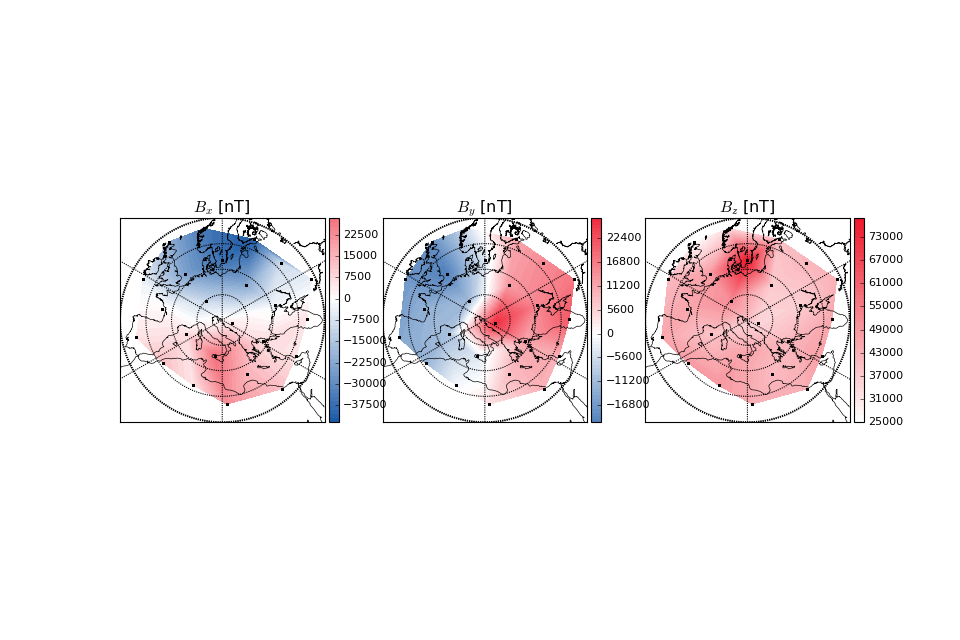

In [112]:
fig, axes = pyplot.subplots(1, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

for Bi, ax, scale in zip((Bx_inv, By_inv, Bz_inv), axes, ("symmetric", "symmetric", "positive")):
    cbar=base.colorbar(scha.polar_tricontour(Bi, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr, scale=scale),
                       location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("$B_{x}$ [nT]"); axes[1].set_title("$B_{y}$ [nT]"); axes[2].set_title("$B_{z}$ [nT]")

<IPython.core.display.Javascript object>


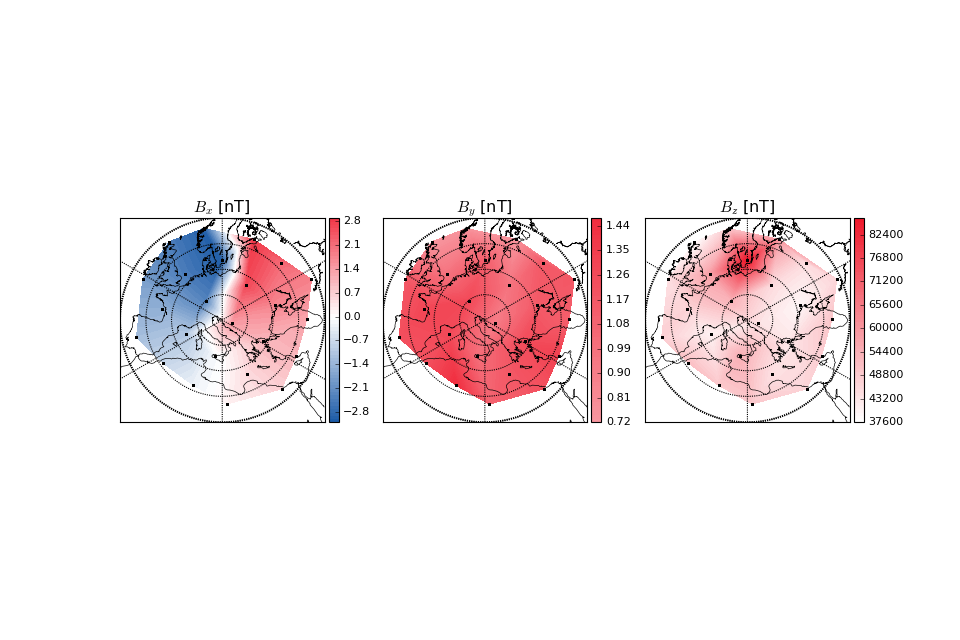

In [113]:
fig, axes = pyplot.subplots(1, 3, figsize=(12,8))

base = Basemap(projection="npstere", lon_0 = 0, boundinglat=90-20)
base2 = Basemap(projection="stere", lon_0 = lon_c, lat_0=lat_c, lat_ts=lat_c,
                width=base.xmax, height=base.ymax, resolution="l")
#scha.polar_contour(Bx_r, theta_r, phi_r, theta_0, ax=ax, resolution=200, base=base)

for Bi, ax, scale in zip((D_inv, I_inv, F_inv), axes, ("symmetric", "symmetric", "positive")):
    cbar=base.colorbar(scha.polar_tricontour(Bi, theta_r, phi_r, theta_0, ax=ax, base=base, cmap=nicebwr, scale=scale),
                       location="right", ax=ax)
    cbar.ax.tick_params(labelsize=10)

for ax in axes:
    base.drawmeridians(numpy.arange(0, 360, 60), latmax=90, ax=ax, color="black")
    base.drawparallels(numpy.linspace(90-20, 90, 5), ax=ax, color="black")
    base.drawparallels([90-numpy.rad2deg(theta_0)],
                       ax=ax, color="black", linewidth=1.8, dashes=[1,1], latmax=90)
    base2.drawcoastlines(ax=ax, linewidth=0.6)
    base.scatter(numpy.rad2deg(phi_r),90-numpy.rad2deg(theta_r),s=2, color="black",latlon=True,ax=ax)
    
axes[0].set_title("$B_{x}$ [nT]"); axes[1].set_title("$B_{y}$ [nT]"); axes[2].set_title("$B_{z}$ [nT]")

<IPython.core.display.Javascript object>


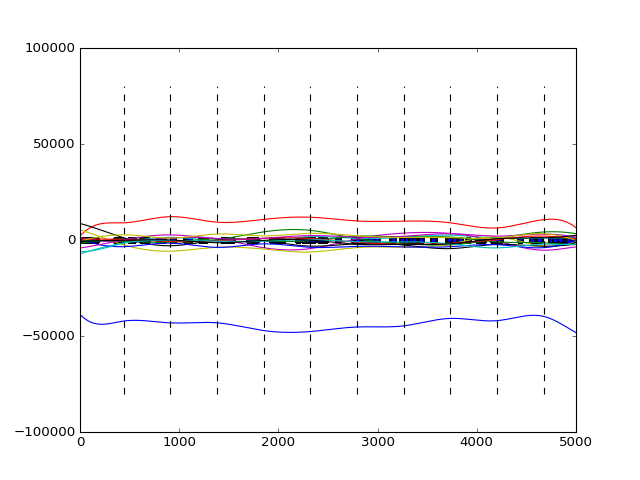

In [114]:
tt = numpy.linspace(0, 5500, 1000)
big=bspline.condition_array(knots, tt) @ gp

fig, ax = pyplot.subplots()

for knot, gc in zip(knots, big.T):
    ax.plot(tt, gc)
    ax.plot([knot, knot], [-80000, 80000], "k--")
    ax.scatter(t, t*0)
    
ax.set_xbound(0, 5000)

In [50]:
def curve_dif_at(theta, phi, theta_c, phi_c, k, m, n, knots, gcoefs, resolution = 2000):
    
    
    theta = numpy.repeat(theta, resolution)
    phi = numpy.repeat(phi, resolution)
    #relocate theta, phi to cap
    rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
    r, theta_r, phi_r = scha.rotate_coords(1.0, theta, phi, rot_mat)
    
    tt = numpy.linspace(knots[0], knots[-1], resolution)
    
    #calculate field
    Bx_r, By_r, Bz_r = scha.xyzfieldt(k, m, n, knots, gcoefs, theta_r, phi_r, tt)
    D_r, I_r, F_r, H_r = xyzfield.xyz2difh(Bx_r, By_r, Bz_r)
    
    #reverse declination to global coords
    D_rr = scha.rotate_declination(D_r, theta_c, phi_c, theta, phi, theta_r, invert=True)
    
    return tt, (D_rr, I_r, F_r)

In [100]:
def points_dif_at(theta, phi, thetav, phiv, t, D, I, F, radius=numpy.deg2rad(5)):
    in_circle = angulardist(theta, phi, thetav, phiv) < radius
    return t[in_circle], (D[in_circle], I[in_circle], F[in_circle])
    

<IPython.core.display.Javascript object>


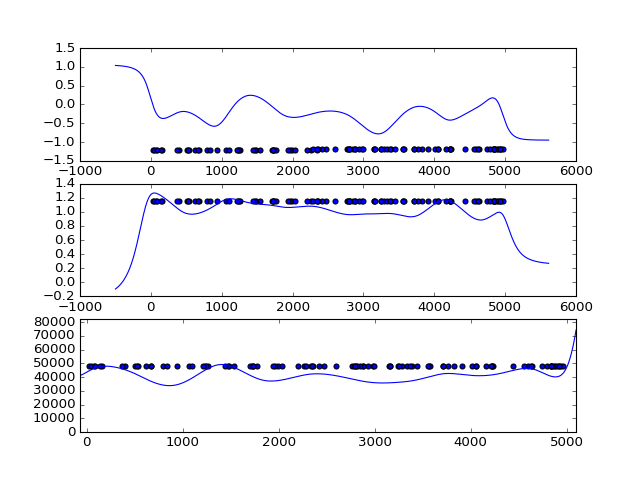

In [109]:
theta_test, phi_test = numpy.deg2rad((90-40.4, -3.7))

tt, (D_test, I_test, F_test) = curve_dif_at(theta_test, phi_test, theta_c, phi_c, k, m, n, knots, gp)
tp, (D_p, I_p, F_p) = points_dif_at(theta_test, phi_test, thetav, phiv, t, D_r, I_r, F_r)

fig, axes = pyplot.subplots(3, 1)

for ax, curve, points in zip(axes, (D_test, I_test, F_test), (D_p, I_p, F_p)):
    ax.plot(tt, curve)
    ax.scatter(tp, points)

In [96]:
tp, (D_p, I_p, F_p) = points_dif_at(theta_test, phi_test, thetav, phiv, t, D_r, I_r, F_r)

In [97]:
tp

array([], dtype=float64)

<IPython.core.display.Javascript object>


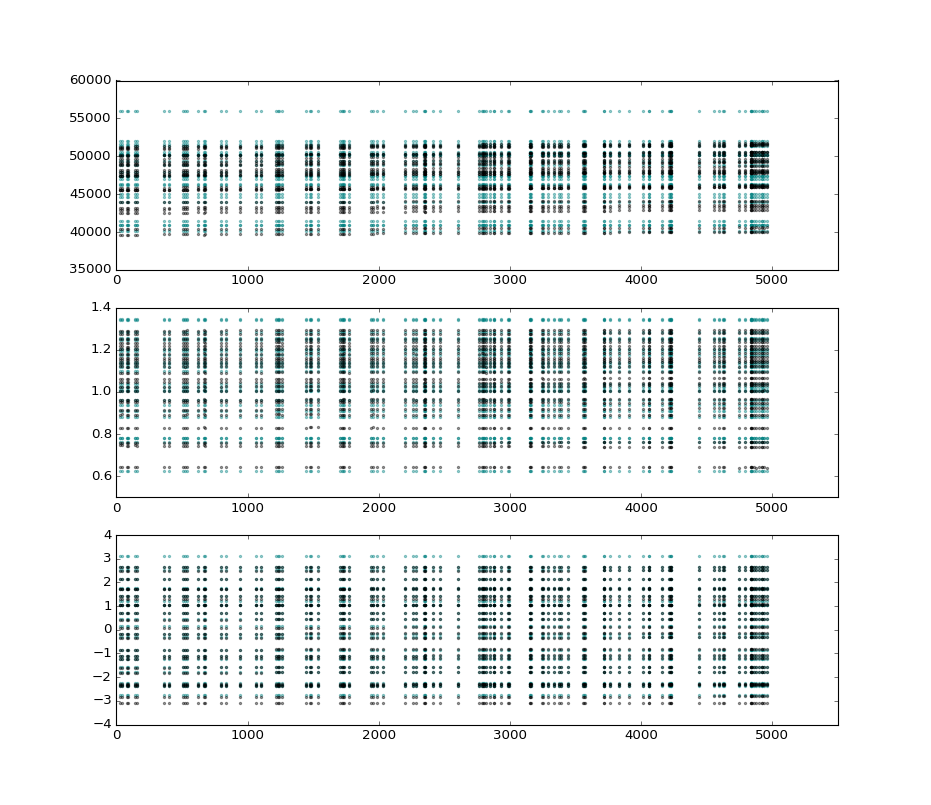

In [57]:
fig, axes = pyplot.subplots(3, 1)

opts = {"s" : 4, "alpha" : 0.4}

axes[0].scatter(t, F_inv, color="teal", **opts)
axes[0].scatter(t, F_r, color="black", **opts)
axes[0].set_xbound(0, 5500)

axes[1].scatter(t, I_inv, color="teal", **opts)
axes[1].scatter(t, I_r, color="black", **opts)
axes[1].set_xbound(0, 5500)

axes[2].scatter(t, D_inv, color="teal", **opts)
axes[2].scatter(t, D_r, color="black", **opts)
axes[2].set_xbound(0, 5500)

pyplot.show(fig)